In [121]:
import pandas as pd

JG_path = "../data/jaguar.csv"
jaguar = pd.read_csv(JG_path)

In [122]:
grouped = jaguar.groupby('tag-local-identifier')
print(grouped.size())

tag-local-identifier
1111        78
2222        93
34691     1296
34770    10989
35957     2820
35959     3340
36312     2682
36313     8347
36314      572
36315     5040
36316      615
36317     2331
36318     4709
dtype: int64


In [123]:
# create dataframe only containing tag-local-identifier of 34770 and 36313
jaguar_34770 = jaguar[jaguar['tag-local-identifier'].isin([34770])]
jaguar_36313 = jaguar[jaguar['tag-local-identifier'].isin([36313])]

In [124]:
# get rid of columns other than timestamp, location-long, location-lat
jaguar_34770 = jaguar_34770[['timestamp', 'location-long', 'location-lat']]
jaguar_34770 = jaguar_34770.dropna(axis=0, how='any', inplace=False)
jaguar_36313 = jaguar_36313[['timestamp', 'location-long', 'location-lat']]
jaguar_36313 = jaguar_36313.dropna(axis=0, how='any', inplace=False)

## General Information 
 Calculate some general information of the total distance (in meters) moved and average moving speed (in meters/day)



In [125]:
# write functions to get the total distance trtaveled and average speed 
# timestamp in formate 2017-05-10 00:00:00.000

data_analyse = jaguar_34770.copy()

def total_distance(df):
    """
    This function calculates the total distance traveled by the animal in meters
    """
    distance = 0
    for i in range(1, len(df)):
        distance += ((df.iloc[i]['location-long'] - df.iloc[i-1]['location-long'])**2 + (df.iloc[i]['location-lat'] - df.iloc[i-1]['location-lat'])**2)**0.5

    # change the distance into meters
    return distance * 111139

def average_speed_per_day(df):
    """
    This function calculates the average speed of the animal in m/day
    """
    distance = total_distance(df)

    time = (pd.to_datetime(df.iloc[-1]['timestamp']) - pd.to_datetime(df.iloc[0]['timestamp'])).days

    return distance / time

print(total_distance(data_analyse))
print(average_speed_per_day(data_analyse))

1367015.523146332
2313.0550307044537


In [126]:
# pip install geopy

In [127]:
import pandas as pd
from geopy.distance import geodesic

def calculate_average_distance_auto_sections(df, interval_minutes=90):
    """
    Calculate the average distance moved for each automatically derived section of the day.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.
        interval_minutes (int): The interval in minutes for grouping timestamps.

    Returns:
        pd.DataFrame: A DataFrame with sections and average distances.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Calculate distances between consecutive points
    def compute_distance(row):
        if pd.isna(row['prev_lat']) or pd.isna(row['prev_long']):
            return 0
        return geodesic((row['prev_lat'], row['prev_long']), (row['location-lat'], row['location-long'])).meters

    df['prev_lat'] = df['location-lat'].shift()
    df['prev_long'] = df['location-long'].shift()
    df['distance'] = df.apply(compute_distance, axis=1)
    
    # Create sections based on intervals
    df['section'] = (df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute) // interval_minutes
    
    # Calculate the average distance for each section
    avg_distances = (
        df.groupby(['section'])['distance']
        .mean()
        .reset_index()
        .rename(columns={'distance': 'avg_distance'})
    )
    
    # Add section labels for clarity
    avg_distances['section_label'] = avg_distances['section'].apply(
        lambda x: f"{(x * interval_minutes) // 60:02d}:{(x * interval_minutes) % 60:02d} to "
                  f"{((x + 1) * interval_minutes) // 60:02d}:{((x + 1) * interval_minutes) % 60:02d}"
    )
    
    return avg_distances

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
average_distances = calculate_average_distance_auto_sections(data_analyse)

# Display the result
print(average_distances)




    section  avg_distance   section_label
0         0    167.056510  00:00 to 01:30
1         1    132.057627  01:30 to 03:00
2         2    157.046105  03:00 to 04:30
3         3    116.997127  04:30 to 06:00
4         4    101.207518  06:00 to 07:30
5         5     89.608060  07:30 to 09:00
6         6     76.785160  09:00 to 10:30
7         7     80.941726  10:30 to 12:00
8         8     76.230025  12:00 to 13:30
9         9    112.215588  13:30 to 15:00
10       10     74.846513  15:00 to 16:30
11       12    150.728658  18:00 to 19:30
12       13    204.339490  19:30 to 21:00
13       14    287.900671  21:00 to 22:30


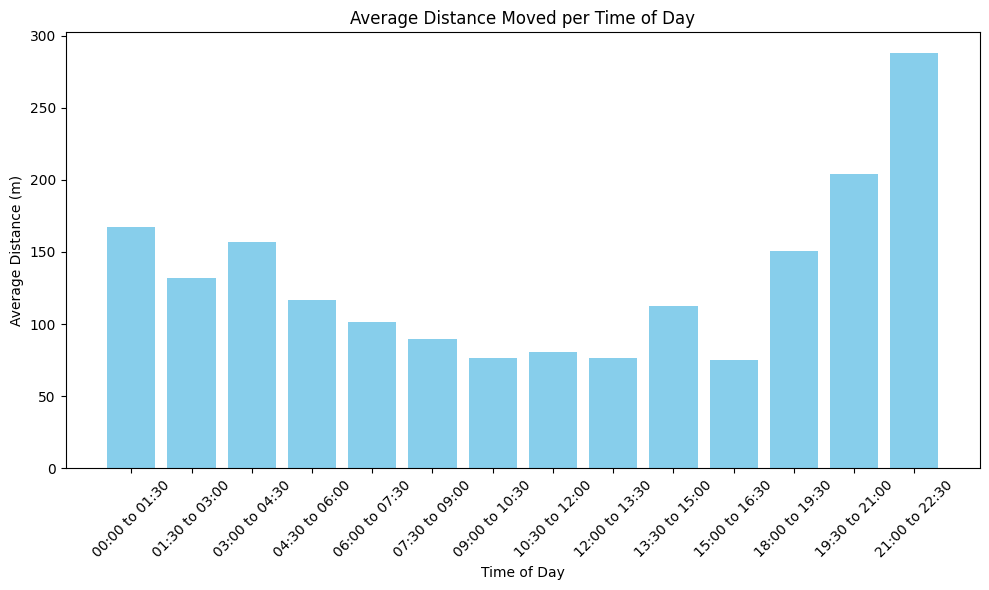

In [128]:
# visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(average_distances['section_label'], average_distances['avg_distance'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Average Distance (m)')
plt.xlabel('Time of Day')
plt.title('Average Distance Moved per Time of Day')
plt.tight_layout()
plt.show()

In [129]:
def calculate_total_distance_per_day_per_month(df):
    """
    Calculate the total moving distance per day and aggregate it by month.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        pd.DataFrame: A DataFrame with months and the average daily total distance.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Calculate distances between consecutive points
    def compute_distance(row):
        if pd.isna(row['prev_lat']) or pd.isna(row['prev_long']):
            return 0
        return geodesic((row['prev_lat'], row['prev_long']), (row['location-lat'], row['location-long'])).meters

    df['prev_lat'] = df['location-lat'].shift()
    df['prev_long'] = df['location-long'].shift()
    df['distance'] = df.apply(compute_distance, axis=1)
    
    # Extract the day and month from the timestamp
    df['day'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.to_period('M')
    
    # Calculate total distance per day
    daily_total = (
        df.groupby(['day'])['distance']
        .sum()
        .reset_index()
        .rename(columns={'distance': 'total_distance_per_day'})
    )
    
    # Aggregate by month to get the average daily total distance
    monthly_avg = (
        daily_total.groupby(daily_total['day'].apply(lambda x: x.strftime('%Y-%m')))['total_distance_per_day']
        .mean()
        .reset_index()
        .rename(columns={'day': 'month', 'total_distance_per_day': 'avg_daily_total_distance'})
    )
    
    return monthly_avg

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
monthly_avg_distances = calculate_total_distance_per_day_per_month(data_analyse)

# Display the result
print(monthly_avg_distances)

      month  avg_daily_total_distance
0   2013-10               1221.257529
1   2013-11               1819.046978
2   2013-12               1280.282526
3   2014-01               1264.010292
4   2014-02               2518.833047
5   2014-03               2482.960958
6   2014-04               2910.510162
7   2014-05               3402.487623
8   2014-06               2873.224383
9   2014-07               2507.897075
10  2014-08               3011.530274
11  2014-09               1588.896951
12  2014-10               1930.763276
13  2014-11               1770.120808
14  2014-12               2385.384852
15  2015-01               1965.598329
16  2015-02               2971.911849
17  2015-03               3443.325272
18  2015-04               2677.600598
19  2015-05               1085.327478


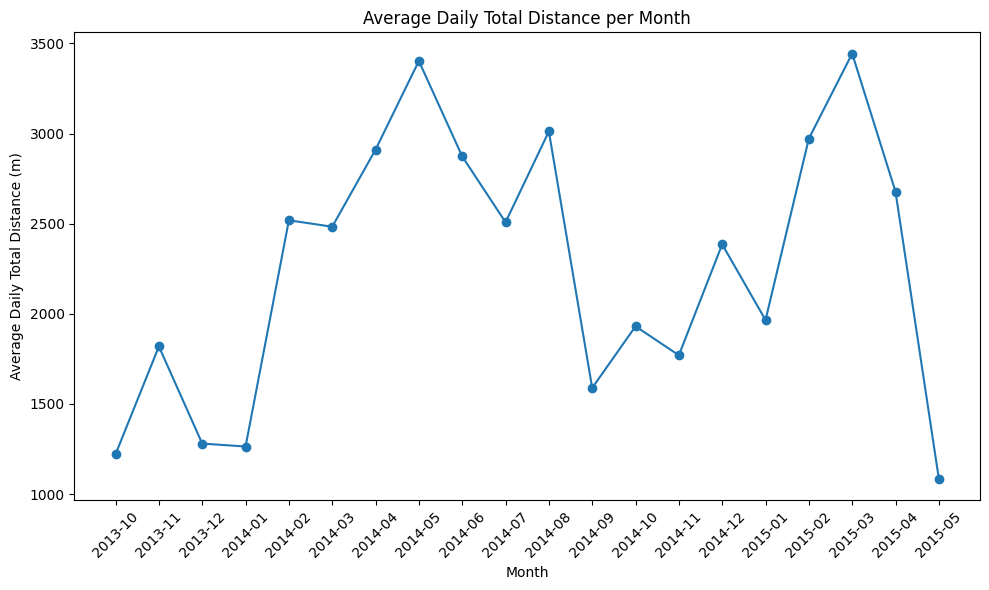

In [130]:
# visualize the result
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_distances['month'], monthly_avg_distances['avg_daily_total_distance'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Average Daily Total Distance (m)')
plt.xlabel('Month')
plt.title('Average Daily Total Distance per Month')
plt.tight_layout()
plt.show()



In [131]:
import pandas as pd
import numpy as np

def calculate_moving_directions(df, interval_minutes=90):
    """
    Calculate the moving directions of an animal at each time section.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.
        interval_minutes (int): Interval in minutes to define sections.

    Returns:
        pd.DataFrame: A DataFrame with sections and predominant moving directions.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Calculate bearings (directions) between consecutive points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        d_lon = lon2 - lon1
        x = np.sin(d_lon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
        initial_bearing = np.arctan2(x, y)
        initial_bearing = np.degrees(initial_bearing)
        return (initial_bearing + 360) % 360  # Normalize to 0-360 degrees

    df['prev_lat'] = df['location-lat'].shift()
    df['prev_long'] = df['location-long'].shift()
    df['bearing'] = df.apply(
        lambda row: calculate_bearing(row['prev_lat'], row['prev_long'], row['location-lat'], row['location-long'])
        if not pd.isna(row['prev_lat']) else None, axis=1
    )
    
    # Assign sections based on intervals
    df['section'] = (df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute) // interval_minutes
    
    # Map bearings to cardinal directions
    def bearing_to_direction(bearing):
        directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
        index = int((bearing + 22.5) // 45) % 8
        return directions[index]

    df['direction'] = df['bearing'].apply(lambda x: bearing_to_direction(x) if not pd.isna(x) else None)
    
    # Analyze predominant direction in each section
    predominant_directions = (
        df.groupby(['section'])['direction']
        .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        .reset_index()
        .rename(columns={'direction': 'predominant_direction'})
    )
    
    # Add section labels for clarity
    predominant_directions['section_label'] = predominant_directions['section'].apply(
        lambda x: f"{(x * interval_minutes) // 60:02d}:{(x * interval_minutes) % 60:02d} to "
                  f"{((x + 1) * interval_minutes) // 60:02d}:{((x + 1) * interval_minutes) % 60:02d}"
    )
    
    return predominant_directions

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
directions_analysis = calculate_moving_directions(data_analyse)

# Display the result
print(directions_analysis)


    section predominant_direction   section_label
0         0                    SW  00:00 to 01:30
1         1                    NE  01:30 to 03:00
2         2                    NW  03:00 to 04:30
3         3                     W  04:30 to 06:00
4         4                    SE  06:00 to 07:30
5         5                     E  07:30 to 09:00
6         6                     E  09:00 to 10:30
7         7                     W  10:30 to 12:00
8         8                     E  12:00 to 13:30
9         9                     W  13:30 to 15:00
10       10                     W  15:00 to 16:30
11       12                     E  18:00 to 19:30
12       13                     E  19:30 to 21:00
13       14                     E  21:00 to 22:30


In [132]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

def calculate_monthly_distance_and_direction(df):
    """
    Calculate the total moving distance and direction for each month by comparing
    the start location of the month to the end location.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        pd.DataFrame: A DataFrame with months, total distance, and direction.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract month from timestamp
    df['month'] = df['timestamp'].dt.to_period('M')
    
    # Sort by timestamp
    df = df.sort_values(by='timestamp')
    
    # Get the first and last location for each month
    monthly_locations = df.groupby('month').agg(
        start_lat=('location-lat', 'first'),
        start_long=('location-long', 'first'),
        end_lat=('location-lat', 'last'),
        end_long=('location-long', 'last')
    ).reset_index()
    
    # Calculate distance and bearing between start and end locations
    def calculate_distance_and_bearing(row):
        start = (row['start_lat'], row['start_long'])
        end = (row['end_lat'], row['end_long'])
        distance = geodesic(start, end).meters
        
        # Calculate bearing
        def calculate_bearing(lat1, lon1, lat2, lon2):
            # Convert degrees to radians
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            d_lon = lon2 - lon1
            x = np.sin(d_lon) * np.cos(lat2)
            y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
            initial_bearing = np.arctan2(x, y)
            initial_bearing = np.degrees(initial_bearing)
            return (initial_bearing + 360) % 360  # Normalize to 0-360 degrees

        bearing = calculate_bearing(row['start_lat'], row['start_long'], row['end_lat'], row['end_long'])
        
        return pd.Series({'total_distance': distance, 'bearing': bearing})
    
    # Apply the distance and bearing calculation
    monthly_locations[['total_distance', 'bearing']] = monthly_locations.apply(
        calculate_distance_and_bearing, axis=1
    )
    
    # Map bearings to cardinal directions
    def bearing_to_direction(bearing):
        directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
        index = int((bearing + 22.5) // 45) % 8
        return directions[index]
    
    monthly_locations['direction'] = monthly_locations['bearing'].apply(bearing_to_direction)
    
    # Select relevant columns
    result = monthly_locations[['month', 'total_distance', 'direction']]
    
    return result

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
monthly_distance_and_direction = calculate_monthly_distance_and_direction(data_analyse)

# Display the result
print(monthly_distance_and_direction)


      month  total_distance direction
0   2013-10     3773.288187         S
1   2013-11     6963.378280        NE
2   2013-12     3977.373768         E
3   2014-01     1974.933977         W
4   2014-02     4599.717472        SW
5   2014-03     1569.906037         E
6   2014-04     1302.584574         S
7   2014-05     6595.555529        NE
8   2014-06     6040.164620        SW
9   2014-07     1054.752443         E
10  2014-08     5976.538055        SE
11  2014-09      268.159848        NE
12  2014-10     1201.381200         S
13  2014-11     4301.566693         E
14  2014-12     2573.370222        SE
15  2015-01     1835.782333         S
16  2015-02     2870.489474         S
17  2015-03     1337.415594         S
18  2015-04      810.764388         N
19  2015-05     1273.310892        NW


In [133]:
# get the most frequent area of the animal
import pandas as pd
from sklearn.cluster import KMeans

def calculate_frequent_areas(df, num_clusters=5):
    """
    This function calculates the most frequent areas visited by an animal.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', and 'location-long' columns.
        num_clusters (int): Number of clusters to use for KMeans clustering.

    Returns:
        pd.DataFrame: A DataFrame with the most frequent areas and their frequencies.

    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Extract the latitude and longitude columns
    X = df[['location-lat', 'location-long']]
    
    # Fit a KMeans clustering model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
    
    # Assign cluster labels to each point
    df['cluster'] = kmeans.predict(X)
    
    # Calculate the frequency of each cluster
    frequent_areas = (
        df.groupby('cluster')
        .size()
        .reset_index(name='frequency')
        .sort_values(by='frequency', ascending=False)
    )
    
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    # Add cluster centers to the frequent areas DataFrame
    frequent_areas['location-lat'] = frequent_areas['cluster'].apply(lambda x: cluster_centers[x][0])
    frequent_areas['location-long'] = frequent_areas['cluster'].apply(lambda x: cluster_centers[x][1])
    
    # Calculate the most frequent time for each cluster appearance
    frequent_times = (
        df.groupby('cluster')['timestamp']
        .apply(lambda x: x.dt.hour.mode()[0] if not x.dt.hour.mode().empty else None)
        .reset_index(name='most_frequent_hour')
    )
    
    # Merge the frequent times with the frequent areas DataFrame
    frequent_areas = frequent_areas.merge(frequent_times, on='cluster')
    
    return frequent_areas

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
frequent_areas = calculate_frequent_areas(data_analyse, 5)
print(frequent_areas)


   cluster  frequency  location-lat  location-long  most_frequent_hour
0        4       4616    -16.875146     -57.489617                  16
1        3       1991    -16.946715     -57.382177                  16
2        0       1778    -16.910993     -57.446231                  16
3        2       1384    -16.985983     -57.385194                  16
4        1       1220    -16.878156     -57.533805                  16


In [134]:
import pandas as pd
from geopy.distance import geodesic

def calculate_distance_stats_between_jaguars(jaguar_df1, jaguar_df2):
    """
    Calculate the average, longest, and shortest distance between two jaguars.

    Args:
        jaguar_df1 (pd.DataFrame): DataFrame containing data for the first jaguar with 'timestamp', 'location-lat', 'location-long' columns.
        jaguar_df2 (pd.DataFrame): DataFrame containing data for the second jaguar with 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        dict: A dictionary with the average, longest, and shortest distance.
    """
    # Ensure the timestamp is in datetime format
    jaguar_df1['timestamp'] = pd.to_datetime(jaguar_df1['timestamp'])
    jaguar_df2['timestamp'] = pd.to_datetime(jaguar_df2['timestamp'])
    
    # Merge the two DataFrames on the nearest timestamps
    merged = pd.merge_asof(
        jaguar_df1.sort_values(by='timestamp'),
        jaguar_df2.sort_values(by='timestamp'),
        on='timestamp',
        suffixes=('_jaguar1', '_jaguar2'),
        direction='nearest'  # Match the closest timestamp
    )
    
    # Calculate the distance between the two jaguars
    def calculate_distance(row):
        jaguar1_location = (row['location-lat_jaguar1'], row['location-long_jaguar1'])
        jaguar2_location = (row['location-lat_jaguar2'], row['location-long_jaguar2'])
        return geodesic(jaguar1_location, jaguar2_location).meters

    merged['distance'] = merged.apply(calculate_distance, axis=1)
    
    # Compute statistics
    average_distance = merged['distance'].mean()
    longest_distance = merged['distance'].max()
    shortest_distance = merged['distance'].min()
    
    # Return the results as a dictionary
    return {
        'average_distance': average_distance,
        'longest_distance': longest_distance,
        'shortest_distance': shortest_distance
    }

# Example usage
# Assuming `jaguar1_df` and `jaguar2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
distance_stats = calculate_distance_stats_between_jaguars(jaguar_34770, jaguar_36313)

# Display the result
print(distance_stats)


{'average_distance': np.float64(7543.193683955073), 'longest_distance': np.float64(19935.17504146827), 'shortest_distance': np.float64(1777.9387790408405)}


In [135]:
import pandas as pd
from geopy.distance import geodesic

def calculate_monthly_average_distance_between_jaguars(jaguar_df1, jaguar_df2):
    """
    Calculate the average distance between two jaguars for each month.

    Args:
        jaguar_df1 (pd.DataFrame): DataFrame containing data for the first jaguar with 'timestamp', 'location-lat', 'location-long' columns.
        jaguar_df2 (pd.DataFrame): DataFrame containing data for the second jaguar with 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        pd.DataFrame: A DataFrame with each month and the corresponding average distance.
    """
    # Ensure the timestamp is in datetime format
    jaguar_df1['timestamp'] = pd.to_datetime(jaguar_df1['timestamp'])
    jaguar_df2['timestamp'] = pd.to_datetime(jaguar_df2['timestamp'])
    
    # Merge the two DataFrames on the nearest timestamps
    merged = pd.merge_asof(
        jaguar_df1.sort_values(by='timestamp'),
        jaguar_df2.sort_values(by='timestamp'),
        on='timestamp',
        suffixes=('_jaguar1', '_jaguar2'),
        direction='nearest'  # Match the closest timestamp
    )
    
    # Calculate the distance between the two jaguars
    def calculate_distance(row):
        jaguar1_location = (row['location-lat_jaguar1'], row['location-long_jaguar1'])
        jaguar2_location = (row['location-lat_jaguar2'], row['location-long_jaguar2'])
        return geodesic(jaguar1_location, jaguar2_location).meters

    merged['distance'] = merged.apply(calculate_distance, axis=1)
    
    # Extract the month from the timestamp
    merged['month'] = merged['timestamp'].dt.to_period('M')
    
    # Calculate the average distance for each month
    monthly_avg_distance = merged.groupby('month')['distance'].mean().reset_index()
    monthly_avg_distance.rename(columns={'distance': 'average_distance'}, inplace=True)
    
    return monthly_avg_distance

# Example usage
# Assuming `jaguar1_df` and `jaguar2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
monthly_distance_stats = calculate_monthly_average_distance_between_jaguars(jaguar_34770, jaguar_36313)

# Display the result
print(monthly_distance_stats)


      month  average_distance
0   2013-10      10811.781056
1   2013-11       8414.982317
2   2013-12       6131.386917
3   2014-01       4137.178862
4   2014-02       7894.224047
5   2014-03       7092.690563
6   2014-04       6713.092725
7   2014-05       6633.295094
8   2014-06       6895.678435
9   2014-07       7151.650713
10  2014-08       6470.543724
11  2014-09       3977.113199
12  2014-10       4182.735891
13  2014-11       6384.265212
14  2014-12       8411.271279
15  2015-01       8799.578011
16  2015-02      10510.138748
17  2015-03      10845.499874
18  2015-04      12301.897573
19  2015-05      12481.030868


In [136]:
print(jaguar_36313[:3])

                timestamp  location-long  location-lat
21898 2014-12-05 17:58:00     -57.435069    -16.876063
21899 2014-12-05 18:00:14     -57.435147    -16.876118
21900 2014-12-05 19:00:27     -57.435169    -16.876319


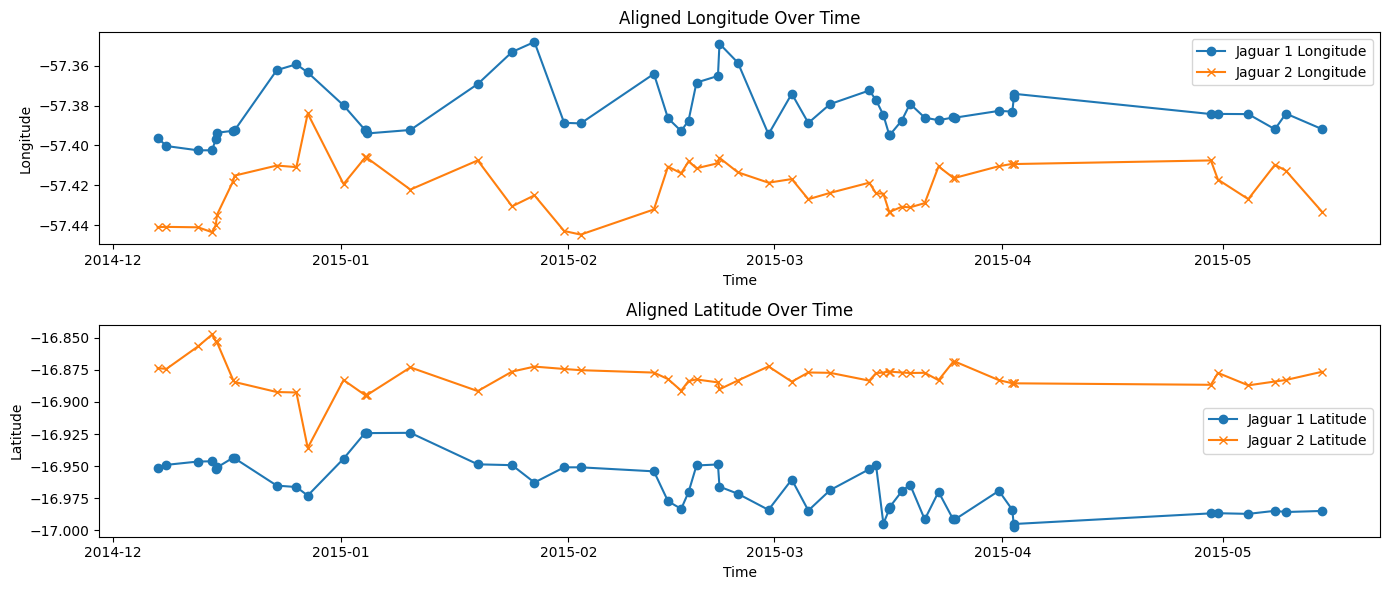

{'pearson_corr_long': np.float64(0.3980293888996236), 'pearson_corr_lat': np.float64(0.03965415085807323)}


In [137]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.signal import correlate
import matplotlib.pyplot as plt

def analyze_jaguar_correlation_aligned(df1, df2):
    """
    Analyze the correlation between the movement patterns of two jaguars based on longitude and latitude,
    aligning data points by timestamp.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguar 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguar 2.

    Returns:
        dict: Pearson correlations for longitude and latitude after alignment.
    """
    # Merge DataFrames on timestamp
    merged_df = pd.merge(df1, df2, on='timestamp', suffixes=('_jaguar1', '_jaguar2'))
    
    # Extract aligned data
    time = pd.to_datetime(merged_df['timestamp'])
    jaguar1_long = merged_df['location-long_jaguar1'].values
    jaguar1_lat = merged_df['location-lat_jaguar1'].values
    jaguar2_long = merged_df['location-long_jaguar2'].values
    jaguar2_lat = merged_df['location-lat_jaguar2'].values

    # Pearson correlation for longitude and latitude
    corr_long, _ = pearsonr(jaguar1_long, jaguar2_long)
    corr_lat, _ = pearsonr(jaguar1_lat, jaguar2_lat)

    # Plot aligned trajectories
    plt.figure(figsize=(14, 6))
    
    # Longitude comparison
    plt.subplot(2, 1, 1)
    plt.plot(time, jaguar1_long, label='Jaguar 1 Longitude', marker='o')
    plt.plot(time, jaguar2_long, label='Jaguar 2 Longitude', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Longitude')
    plt.title('Aligned Longitude Over Time')
    plt.legend()

    # Latitude comparison
    plt.subplot(2, 1, 2)
    plt.plot(time, jaguar1_lat, label='Jaguar 1 Latitude', marker='o')
    plt.plot(time, jaguar2_lat, label='Jaguar 2 Latitude', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Latitude')
    plt.title('Aligned Latitude Over Time')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Return Pearson correlation results
    return {
        'pearson_corr_long': corr_long,
        'pearson_corr_lat': corr_lat,
    }




# Example usage
# Assuming `jaguar1_df` and `jaguar2_df` are your DataFrames with 'time', 'x', and 'y'
movement_correlation = analyze_jaguar_correlation_aligned(jaguar_34770, jaguar_36313)
print(movement_correlation)


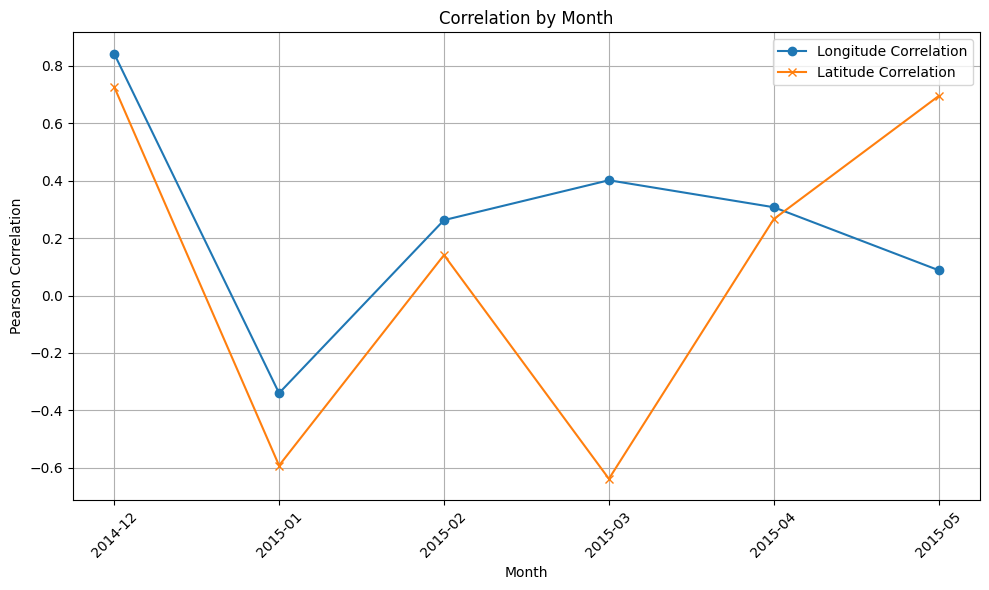

     month  pearson_corr_long  pearson_corr_lat
0  2014-12           0.841791          0.726518
1  2015-01          -0.339686         -0.591570
2  2015-02           0.262313          0.140872
3  2015-03           0.401062         -0.637861
4  2015-04           0.307128          0.266181
5  2015-05           0.087841          0.694426


In [138]:
def analyze_jaguar_correlation_by_month(df1, df2):
    """
    Analyze the correlation between two jaguars' movement patterns by month,
    aligning data points by timestamp.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguar 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguar 2.

    Returns:
        pd.DataFrame: Correlation results (longitude and latitude) grouped by month.
    """
    # Convert timestamps to datetime objects
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Add month column for grouping
    df1['month'] = df1['timestamp'].dt.to_period('M')
    df2['month'] = df2['timestamp'].dt.to_period('M')

    # Merge DataFrames on timestamp
    merged_df = pd.merge(df1, df2, on='timestamp', suffixes=('_jaguar1', '_jaguar2'))
    merged_df['month'] = merged_df['timestamp'].dt.to_period('M')

    # Group by month and calculate Pearson correlations
    results = []
    for month, group in merged_df.groupby('month'):
        jaguar1_long = group['location-long_jaguar1'].values
        jaguar1_lat = group['location-lat_jaguar1'].values
        jaguar2_long = group['location-long_jaguar2'].values
        jaguar2_lat = group['location-lat_jaguar2'].values

        if len(jaguar1_long) > 1:  # Pearson correlation requires at least 2 points
            corr_long, _ = pearsonr(jaguar1_long, jaguar2_long)
            corr_lat, _ = pearsonr(jaguar1_lat, jaguar2_lat)
        else:
            corr_long, corr_lat = np.nan, np.nan  # Not enough data for correlation

        results.append({'month': month, 'pearson_corr_long': corr_long, 'pearson_corr_lat': corr_lat})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot correlations by month
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_long'], label='Longitude Correlation', marker='o')
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_lat'], label='Latitude Correlation', marker='x')
    plt.xlabel('Month')
    plt.ylabel('Pearson Correlation')
    plt.title('Correlation by Month')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

# Example usage

# Assuming `jaguar1_df` and `jaguar2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
monthly_correlation = analyze_jaguar_correlation_by_month(jaguar_34770, jaguar_36313)
print(monthly_correlation)

In [139]:
def analyze_jaguar_correlation_end_of_day(df1, df2):
    """
    Analyze the correlation between the movement patterns of two jaguars based on longitude and latitude,
    using only the location at the end of each day.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguar 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguar 2.

    Returns:
        dict: Pearson correlations for longitude and latitude after alignment.
    """
    # Convert timestamps to datetime objects
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Group by date and select the last record for each day
    df1_end_of_day = df1.groupby(df1['timestamp'].dt.date).last().reset_index(drop=True)
    df2_end_of_day = df2.groupby(df2['timestamp'].dt.date).last().reset_index(drop=True)

    # Merge DataFrames on timestamp
    merged_df = pd.merge(df1_end_of_day, df2_end_of_day, on='timestamp', suffixes=('_jaguar1', '_jaguar2'))
    
    # Extract aligned data
    time = pd.to_datetime(merged_df['timestamp'])
    jaguar1_long = merged_df['location-long_jaguar1'].values
    jaguar1_lat = merged_df['location-lat_jaguar1'].values
    jaguar2_long = merged_df['location-long_jaguar2'].values
    jaguar2_lat = merged_df['location-lat_jaguar2'].values

    # Pearson correlation for longitude and latitude
    corr_long, _ = pearsonr(jaguar1_long, jaguar2_long)
    corr_lat, _ = pearsonr(jaguar1_lat, jaguar2_lat)

    # Plot aligned end-of-day trajectories
    plt.figure(figsize=(14, 6))
    
    # Longitude comparison
    plt.subplot(2, 1, 1)
    plt.plot(time, jaguar1_long, label='jaguar 1 Longitude', marker='o')
    plt.plot(time, jaguar2_long, label='jaguar 2 Longitude', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Longitude')
    plt.title('End-of-Day Longitude Over Time')
    plt.legend()

    # Latitude comparison
    plt.subplot(2, 1, 2)
    plt.plot(time, jaguar1_lat, label='jaguar 1 Latitude', marker='o')
    plt.plot(time, jaguar2_lat, label='jaguar 2 Latitude', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Latitude')
    plt.title('End-of-Day Latitude Over Time')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Return Pearson correlation results
    return {
        'pearson_corr_long': corr_long,
        'pearson_corr_lat': corr_lat,
    }


# Example usage
# Assuming `jaguar1_df` and `jaguar2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
end_of_day_correlation = analyze_jaguar_correlation_end_of_day(jaguar_34770, jaguar_36313)
print(end_of_day_correlation)


ValueError: `x` and `y` must have length at least 2.

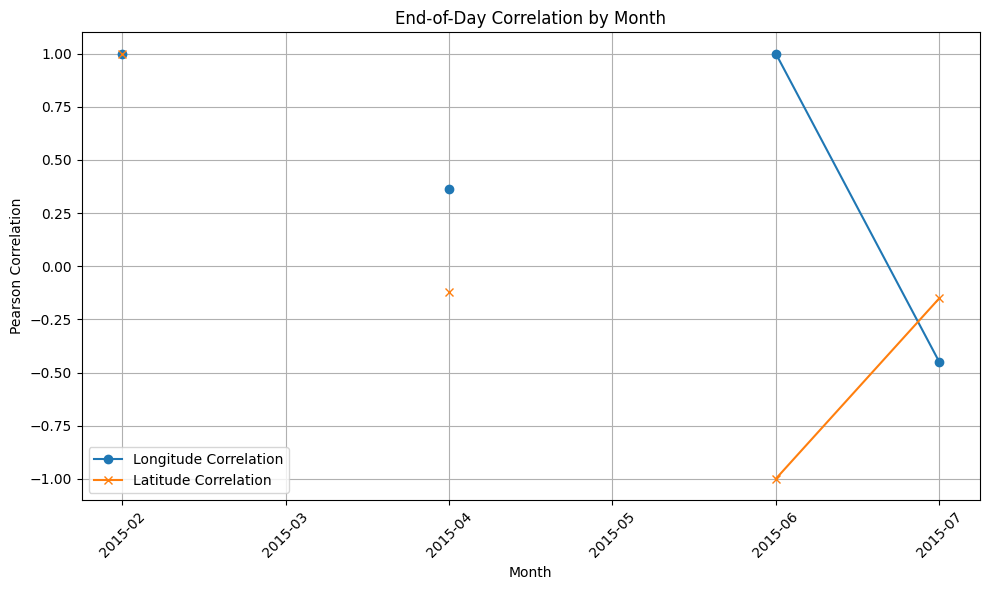

     month  pearson_corr_long  pearson_corr_lat
0  2014-12                NaN               NaN
1  2015-02           1.000000          1.000000
2  2015-03                NaN               NaN
3  2015-04           0.362952         -0.119507
4  2015-05                NaN               NaN
5  2015-06           1.000000         -1.000000
6  2015-07          -0.449295         -0.151507


In [ ]:
def analyze_jaguars_correlation_end_of_day_by_month(df1, df2):
    """
    Analyze the correlation between the movement patterns of two jaguars based on longitude and latitude,
    using only the location at the end of each day and grouping by month.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguars 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for jaguars 2.

    Returns:
        pd.DataFrame: Correlation results (longitude and latitude) grouped by month.
    """
    # Convert timestamps to datetime objects
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Group by date and select the last record for each day
    df1_end_of_day = df1.groupby(df1['timestamp'].dt.date).last().reset_index(drop=True)
    df2_end_of_day = df2.groupby(df2['timestamp'].dt.date).last().reset_index(drop=True)

    # Add a month column for grouping
    df1_end_of_day['month'] = df1_end_of_day['timestamp'].dt.to_period('M')
    df2_end_of_day['month'] = df2_end_of_day['timestamp'].dt.to_period('M')

    # Merge the end-of-day DataFrames
    merged_df = pd.merge(
        df1_end_of_day,
        df2_end_of_day,
        on='timestamp',
        suffixes=('_jaguars1', '_jaguars2')
    )

    # Add a month column to the merged DataFrame
    merged_df['month'] = merged_df['timestamp'].dt.to_period('M')

    # Group by month and calculate Pearson correlations
    results = []
    for month, group in merged_df.groupby('month'):
        jaguars1_long = group['location-long_jaguars1'].values
        jaguars1_lat = group['location-lat_jaguars1'].values
        jaguars2_long = group['location-long_jaguars2'].values
        jaguars2_lat = group['location-lat_jaguars2'].values

        # Ensure there are at least two data points for correlation
        if len(jaguars1_long) > 1:
            corr_long, _ = pearsonr(jaguars1_long, jaguars2_long)
            corr_lat, _ = pearsonr(jaguars1_lat, jaguars2_lat)
        else:
            corr_long, corr_lat = np.nan, np.nan  # Not enough data for correlation

        results.append({'month': month, 'pearson_corr_long': corr_long, 'pearson_corr_lat': corr_lat})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plot correlations by month
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_long'], label='Longitude Correlation', marker='o')
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_lat'], label='Latitude Correlation', marker='x')
    plt.xlabel('Month')
    plt.ylabel('Pearson Correlation')
    plt.title('End-of-Day Correlation by Month')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df




# Example usage
# Assuming `jaguars1_df` and `jaguars2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
monthly_correlation = analyze_jaguars_correlation_end_of_day_by_month(jaguar_34770, jaguar_36313)
print(monthly_correlation)